In [ ]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

# df_annotations = pd.read_csv("all_annotations.csv")


# Get data

In [ ]:
# with open("protocols.pkl.gz", "rb") as f:
#     file_to_pages = pkl.load(f)

In [ ]:
# import spacy
# nlp = spacy.blank("en")

In [ ]:
# texts = []

# for i in range(len(df_annotations)):
#     file_name = df_annotations.file.iloc[i]
    
#     pages= file_to_pages[file_name]
    
#     text = ""
#     for page in pages:
#         doc = nlp(page)
        
#         is_include = [False] * len(doc)
#         for tok in doc:
#             if tok.text.lower() in {"phase"}:
#                 for token_index in range(tok.i - 20, tok.i + 20):
#                     if token_index >= 0 and token_index < len(doc):
#                         is_include[token_index] = True
        
#         for token_index in range(len(doc)):
#             if is_include[token_index]:
#                 text += doc[token_index].text + doc[token_index].whitespace_
                
                
#     if text == "":
#         print ("nothing found", file_name, df_annotations.phase.iloc[i])
#         text = " ".join(pages)
#         if len(text) > 100000:
#             text = text[:100000]
#     else:
#         print ("found", file_name, df_annotations.phase.iloc[i])

#     texts.append(text)
# df_annotations["text"] = texts

In [ ]:
# df_annotations.to_csv("filtered_for_phase.csv.bz2")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_annotations= pd.read_csv("/content/drive/MyDrive/data/filtered_for_phase_arms_subjects.csv.bz2")

Override the subjects column with more up to date data

In [ ]:
annots_with_subject = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")

In [ ]:
(~df_annotations.num_subjects.isna()).sum(), (~annots_with_subject.num_subjects.isna()).sum()

(418, 11920)

In [ ]:
df_annotations["num_subjects"] = annots_with_subject["num_subjects"]

In [ ]:
def get_num_subjects_clean(num):
    if pd.isna(num):
        return None
    if num >= 10000:
        return "10000+"
    if num >= 1000:
        return "1000+"
    if num >= 500:
        return "500+"
    if num >= 200:
        return "200+"
    if num >= 100:
        return "100+"
    if num >= 50:
        return "50+"
    if num >= 25:
        return "25+"
    return "1-24"
df_annotations["num_subjects_clean"] = df_annotations["num_subjects"].apply(get_num_subjects_clean)

In [ ]:
df_annotations["num_subjects_clean"].value_counts()

1-24      2980
25+       2119
50+       2016
100+      1674
200+      1656
500+       816
1000+      547
10000+     112
Name: num_subjects_clean, dtype: int64

In [ ]:
# df_annotations = pd.read_csv("filtered_for_phase.csv.bz2")

In [ ]:
# del file_to_pages

In [ ]:
phase_map = {"Phase 2":"2",
"Phase 3":"3",
"Phase 4":"4",
"Phase 1":"1",
"Phase 1/Phase 2":"1.5",
"Not Applicable":"0",
"Phase 2/Phase 3":"2.5",
"Early Phase 1":"0.5"}
df_annotations["phase_clean"] = df_annotations["phase"].apply(lambda x : phase_map.get(x, None))

In [ ]:
def get_num_arms_clean(num):
    if pd.isna(num):
        return None
    if num >= 5:
        num = 5
    return num
df_annotations["num_arms_clean"] = df_annotations["num_arms"].apply(get_num_arms_clean)

In [ ]:
df_train = df_annotations[df_annotations.train_val == "train"]
df_val = df_annotations[df_annotations.train_val == "val"]

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [ ]:
NUM_FEATURES = 1500

stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
stops.remove("both")
stops.remove("all")

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, stop_words=stops, min_df=5, max_features=NUM_FEATURES,
                             token_pattern=r'[59][05]%?(?:ci)?|[a-z][a-z]+')
transformer = TfidfTransformer()

nb = MultinomialNB()
model = make_pipeline(vectoriser, transformer, nb)

In [ ]:
model.fit(df_train[~pd.isna(df_train.num_subjects_clean)].text, df_train[~pd.isna(df_train.num_subjects_clean)].num_subjects_clean)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1500, min_df=5,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'au',
                                             'aura', 'aurai', 'auraient',
                                             'aurais', 'aurait', 'auras',
                                             'aurez', 'auriez', ...},
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

In [ ]:
df_val["y_pred_num_subjects"] = model.predict(df_val.text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
acc = accuracy_score(df_val.num_subjects_clean, df_val["y_pred_num_subjects"])
print (f"Subjects accuracy {acc}")

Subjects accuracy 0.29400921658986173


''

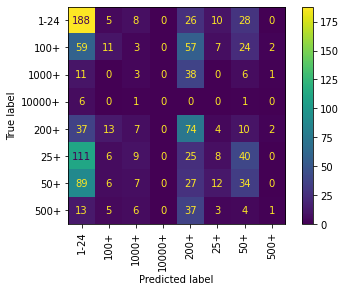

In [ ]:
ConfusionMatrixDisplay.from_predictions(df_val.num_subjects_clean, df_val["y_pred_num_subjects"])
plt.xticks(rotation=90)
;

array(['1-24', '100+', '1000+', '10000+', '200+', '25+', '50+', '500+'],
      dtype='<U6')

In [ ]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in range(5):
    print(f"Strongest predictors for class {prediction_idx} {model.classes_[prediction_idx]}\n")
    for i in range(transformed_document.shape[1]):
        zeros = np.zeros(transformed_document.shape)
        zeros[0, i] = transformed_document[0, i]
        proba = nb.predict_log_proba(zeros)
        probas[i] = proba[0, prediction_idx]

    for ctr, j in enumerate(np.argsort(-probas)):
        for w, i in vectoriser.vocabulary_.items():
            if i == j:
                print(f"{ctr}\t{w}")
        if ctr > 10:
          break

Strongest predictors for class 0 1-24

0	hgt
1	pilot
2	dlt
3	myeloma
4	everolimus
5	transplantation
6	melanoma
7	mtd
8	merc
9	tak
10	stool
11	ial
Strongest predictors for class 1 100+

0	efc
1	influenza
2	sage
3	bms
4	block
5	qd
6	hcv
7	allocated
8	ip
9	medi
10	fracture
11	roche
Strongest predictors for class 2 1000+

0	efc
1	shaft
2	sanofi
3	sar
4	hba
5	blis
6	vaccination
7	vir
8	encounter
9	writt
10	assi
11	pir
Strongest predictors for class 3 10000+

0	shaft
1	encounter
2	fracture
3	hgt
4	sage
5	efc
6	blis
7	assi
8	osis
9	difi
10	writt
11	ofil
Strongest predictors for class 4 200+

0	efc
1	tho
2	xte
3	sanofi
4	riz
5	hba
6	tb
7	roche
8	ov
9	vaccination
10	influenza
11	hazard
